## NeurIPS Paramater Count analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-13 15:45:21.624123: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 15:45:22.594876: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 15:45:22.886241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 15:45:22.887541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [6]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *
from collections import defaultdict

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 9.4%
RAM Usage: 5.7%
Available RAM: 355.4G
Total RAM: 377.1G
52.4G


## Wandb API Query <a id="sims"></a>

Data load

In [11]:
from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels

from models.bilinear import BilinearCM, BilinearLowRank
from models.dynamic_mlp import DynamicMLP
from models.smt import SharedSelfAttentionModel, SharedSelfAttentionCLSModel
from models.smt_cross import CrossAttentionGeneVecModel

# Load data
print("Loading data...")

full_gene_list='0.2'
hvg_gene_list='100_var'

# Load two versions of gene expression data based on gene lists
X_full, valid_genes_full = load_transcriptome(parcellation='S456', gene_list=full_gene_list, hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate', return_valid_genes=True)
X_hvg, valid_genes_hvg = load_transcriptome(parcellation='S456', gene_list=hvg_gene_list, hemisphere='both', omit_subcortical=False, sort_genes='refgenome', impute_strategy='mirror_interpolate', return_valid_genes=True)

Y = load_connectome(parcellation='S456', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S456', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S456', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X_full).all(axis=1)

# Subset all data using valid indices
X_full_valid = X_full[valid_indices]
X_hvg_valid = X_hvg[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# prepare data loaders for each type
X_full = torch.tensor(X_full_valid, dtype=torch.float32).to("cuda")
X_hvg = torch.tensor(X_hvg_valid, dtype=torch.float32).to("cuda")
coords = torch.tensor(coords_valid, dtype=torch.float32).to("cuda")

# Create datasets
dataset_full = TensorDataset(X_full, coords)
dataset_hvg = TensorDataset(X_hvg, coords)

# Create dataloaders
dataloader_full = DataLoader(dataset_full, batch_size=X_full_valid.shape[0], shuffle=False)
dataloader_hvg = DataLoader(dataset_hvg, batch_size=X_hvg_valid.shape[0], shuffle=False)

Loading data...


In [15]:
from data.data_utils import RegionPairDataset

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Create full pairwise dataset
print("Creating full and HVG pairwise datasets...")

# Create full pairwise dataset
full_dataset = RegionPairDataset(
    X=X_full_valid,
    Y=Y_valid, 
    coords=coords_valid,
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_full
)

# Create HVG pairwise dataset
hvg_dataset = RegionPairDataset(
    X=X_hvg_valid,
    Y=Y_valid,
    coords=coords_valid, 
    dataset='UKBB',
    parcellation='S456',
    valid2true_mapping=valid2true_mapping,
    valid_genes=valid_genes_hvg
)

print(f"Full dataset: {len(full_dataset)} region pairs")
print(f"HVG dataset: {len(hvg_dataset)} region pairs")

# Create dataloaders
full_dataloader = DataLoader(
    full_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

hvg_dataloader = DataLoader(
    hvg_dataset,
    batch_size=512, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


Creating full and HVG pairwise datasets...
Full dataset: 206570 region pairs
HVG dataset: 206570 region pairs


In [ ]:
# Initialize models with best parameters for each gene list

# Bilinear CM
bilinear_cm_hvg = BilinearCM(
    input_dim=X_hvg.shape[1]*2,
    learning_rate=0.0005,
    batch_size=512,
    regularization='l2',
    lambda_reg=0.1
).to('cuda')

# Bilinear Lowrank
bilinear_lr_hvg = BilinearLowRank(
    input_dim=X_hvg.shape[1]*2,
    activation='none',
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2', 
    lambda_reg=0.001,
    shared_weights=True,
    reduced_dim=10
).to('cuda')

bilinear_lr_full = BilinearLowRank(
    input_dim=X_full.shape[1]*2,
    activation='none', 
    learning_rate=0.0001,
    batch_size=256,
    regularization='l2',
    lambda_reg=0.001,
    shared_weights=True,
    reduced_dim=10
).to('cuda')

# Dynamic MLP
dynamic_mlp_hvg = DynamicMLP(
    input_dim=X_hvg.shape[1]*2,
    hidden_dims=[512, 256, 128],
    learning_rate=0.00009,
    batch_size=512,
    dropout_rate=0.1,
    weight_decay=0.0001
).to('cuda')

# Cross Attention GeneVec
cross_attention_hvg = CrossAttentionGeneVecModel(
    input_dim=X_hvg.shape[1],
    region_pair_dataset=hvg_dataset,
    expression_bins=5,
    genevec_type='gene2vec',
    d_model=32,
    nhead=2,
    num_layers=2,
    deep_hidden_dims=[256, 128, 64],
    cls_init='random',
    pooling_mode='attention',
    use_alibi=True,
    transformer_dropout=0.3,
    dropout_rate=0.1,
    learning_rate=0.00009,
    weight_decay=0.001,
    bidirectional=True
    ).to('cuda')

# Shared Transformer (only for full gene list)
shared_transformer_full = SharedSelfAttentionModel(
    input_dim=X_full.shape[1]*2,
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    use_alibi=True,
    nhead=4,
    num_layers=4,
    deep_hidden_dims=[512, 256, 128],
    transformer_dropout=0.2,
    dropout_rate=0.2,
    learning_rate=0.00009,
    weight_decay=0.0001
).to('cuda')

# Dynamic MLP
dynamic_mlp_full = DynamicMLP(
    input_dim=X_full.shape[1]*2,
    hidden_dims=[512, 256, 128],
    learning_rate=0.00009,
    batch_size=512,
    dropout_rate=0.1,
    weight_decay=0.0001
).to('cuda')

Total number of learnable parameters in BilinearCMmodel: 10001
Number of learnable parameters in Bilinear low rank model: 1000
  Linear layer 1: 1000 parameters
Number of learnable parameters in Bilinear low rank model: 73800
  Linear layer 1: 73800 parameters
Number of learnable parameters in MLP: 269057
Using SymmetricLoss with lambda_sym=0.1


  warnings.warn(



Loaded Gene2Vec embeddings: 94 genes with 200-dimensional embeddings
Gene overlap: 94/100 valid genes have Gene2Vec embeddings
Number of learnable parameters in CrossAttentionGeneVec model: 85960
Expression bins: 5
CLS token initialization: random
Number of learnable parameters in SMT model: 2162315
Number of learnable parameters in MLP: 7723777


In [70]:
def fetch_and_summarize_wandb_runs(model, cv_type, null_model, gene_list='0.2', feature_type='transcriptome', target='FC', within_last=60, before_last=0, use_weighted=False, exclude='HCP', return_history=False):
    """
    Fetches wandb runs matching specific tags and summarizes their final train/test metrics.
    Handles different CV types with their expected number of runs:
    - random/spatial: 40 runs
    - schaefer: 9 runs  
    - lobe: 6 runs
    
    Args:
        model (str): Model name, e.g., 'bilinear_CM'
        cv_type (str): CV type, one of: 'random', 'spatial', 'schaefer', 'lobe'
        null_model (str): Null model label, e.g., 'none'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        target (str): Target connectome type, e.g., 'FC'
        within_last (int): Search for runs within this many days ago (default: 60)
        before_last (int): Exclude runs from this many days ago (default: 0)
        use_weighted (bool): Whether to compute weighted statistics for schaefer/lobe CV
        exclude (str): Dataset to exclude from search (default: 'HCP')
        return_history (bool): If True, return (summary_df, history_df) tuple
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
                                  If use_weighted=True and cv_type in ['schaefer', 'lobe'], 
                                  includes weighted_mean and weighted_stderr rows
        history_df (pd.DataFrame): Individual run data (only returned if return_history=True)
    """
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Set expected number of runs based on cv_type
    if cv_type == "schaefer":
        expected_runs = 9
    elif cv_type == "lobe":
        expected_runs = 6
    else:  # random or spatial
        expected_runs = 40
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"target_{target}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}",
                f"gene_list_{gene_list}"  # Fixed: Removed comma and added proper string formatting
            ],
        },
        "created_at": {
            "$gte": start_time.isoformat(), 
            "$lte": end_time.isoformat()
        },
        "state": "finished"
    }
    
    # Add exclusion filter if specified
    if exclude != "":
        filters["tags"]["$nin"] = [f"dataset_{exclude}"]
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        # Extract fold number for weighted calculations
        if use_weighted and cv_type in ['schaefer', 'lobe']:
            fold_match = re.search(r'fold(\d+)', run.name)
            if fold_match:
                metrics['fold'] = int(fold_match.group(1))
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    print(f"📊 Found {len(df)} total runs")

    if len(df) < expected_runs:
        raise ValueError(f"❌ Expected {expected_runs} runs, but found {len(df)}.")

    # Handle deduplication based on CV type
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        # Sort by fold number for proper weight assignment
        df = df.sort_values('fold')
        # Deduplicate by fold keeping highest test pearson_r within each fold
        df_unique = (
            df.sort_values(["fold", "final_test_pearson_r"], ascending=[True, False])
              .drop_duplicates("fold", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique folds, found {len(df_unique)} after deduplication.")
    else:
        # Deduplicate by run_name using highest test pearson_r
        df_unique = (
            df.sort_values("final_test_pearson_r", ascending=False)
              .drop_duplicates("run_name", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique run names, found {len(df_unique)} after deduplication.")

    # Store history before cleaning for aggregation
    history_df = df_unique.copy()
    
    # Clean and summarize
    columns_to_drop = ["run_name", "run_id", "final_test_pearson_r"]
    if 'fold' in df_unique.columns:
        columns_to_drop.append("fold")
    df_clean = df_unique.drop(columns=columns_to_drop, errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T
    
    # Add weighted statistics if requested and applicable
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        weights = list(CV_WEIGHTS[cv_type].values())
        
        # Calculate weighted statistics for final_test_pearson_r
        weighted_mean, weighted_se = weighted_mean_and_se(df_unique['final_test_pearson_r'].values, weights)
        summary_df.loc['weighted_mean', 'final_test_pearson_r'] = weighted_mean
        summary_df.loc['weighted_stderr', 'final_test_pearson_r'] = weighted_se
        
        # Calculate weighted statistics for test_pearson_r if it exists
        if 'test_pearson_r' in df_clean.columns:
            test_pearson_values = df_unique['test_pearson_r'].values if 'test_pearson_r' in df_unique.columns else df_clean['test_pearson_r'].values
            weighted_mean_test, weighted_se_test = weighted_mean_and_se(test_pearson_values, weights)
            summary_df.loc['weighted_mean', 'test_pearson_r'] = weighted_mean_test
            summary_df.loc['weighted_stderr', 'test_pearson_r'] = weighted_se_test

    if return_history:
        return summary_df, history_df
    else:
        return summary_df

In [73]:
# Global parameters for spatial CV
cv_type = 'random'

# Create dictionary to store random results
random_results = {}

# Bilinear lowrank HVG
within_last, before_last = 7, 0
#random_results['bilinear_lowrank_hvg'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear lowrank full
within_last, before_last = 120, 0 
random_results['bilinear_lowrank_full'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM HVG
within_last, before_last = 7, 0
random_results['bilinear_cm_hvg'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP HVG
within_last, before_last = 7, 0
random_results['dynamic_mlp_hvg'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Cross attention genevec HVG
within_last, before_last = 7, 0
random_results['cross_attention_genevec_hvg'] = fetch_and_summarize_wandb_runs('cross_attention_genevec', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Shared transformer full
within_last, before_last = 30, 0
random_results['shared_transformer_full'] = fetch_and_summarize_wandb_runs('shared_transformer', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP full
within_last, before_last = 30, 0
random_results['dynamic_mlp_full'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

🔍 Fetching runs for: model=bilinear_lowrank, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 44 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 162 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=cross_attention_genevec, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 118 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 1216 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs


In [78]:
cv_type = 'spatial'

# Create dictionary to store spatial results
spatial_results = {}

# Bilinear lowrank HVG
within_last, before_last = 7, 0
#spatial_results['bilinear_lowrank_hvg'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear lowrank full
within_last, before_last = 100, 0 
spatial_results['bilinear_lowrank_full'] = fetch_and_summarize_wandb_runs('bilinear_lowrank', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Bilinear CM HVG
within_last, before_last = 7, 0
spatial_results['bilinear_cm_hvg'] = fetch_and_summarize_wandb_runs('bilinear_CM', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP HVG
within_last, before_last = 7, 0
spatial_results['dynamic_mlp_hvg'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Cross attention genevec HVG
within_last, before_last = 7, 0
spatial_results['cross_attention_genevec_hvg'] = fetch_and_summarize_wandb_runs('cross_attention_genevec', cv_type=cv_type, null_model='none', gene_list='100_var', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Shared transformer full
within_last, before_last = 10, 0
spatial_results['shared_transformer_full'] = fetch_and_summarize_wandb_runs('shared_transformer', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

# Dynamic MLP full
within_last, before_last = 60, 0
spatial_results['dynamic_mlp_full'] = fetch_and_summarize_wandb_runs('dynamic_mlp', cv_type=cv_type, null_model='none', gene_list='0.2', feature_type='transcriptome', target='FC', within_last=within_last, before_last=before_last, use_weighted=False, exclude='HCP', return_history=False)

🔍 Fetching runs for: model=bilinear_lowrank, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=bilinear_CM, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 160 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=cross_attention_genevec, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 78 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 562 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=dynamic_mlp, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 80 total runs
📊 After deduplication: 40 unique runs


In [79]:
def plot_param_count_vs_performance(random_results, spatial_results, metric='test_long_r'):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Dictionary to store parameter counts for each model
    param_counts = {
        'bilinear_cm_hvg': 10001,  # HVG gene set 
        'bilinear_lowrank_hvg': 1000,  # HVG gene set
        'bilinear_lowrank_full': 73800,  # 0.2 gene set
        'dynamic_mlp_hvg': 269057,  # HVG gene set
        'cross_attention_genevec_hvg': 85960,  # HVG gene set 
        'shared_transformer_full': 2162315,  # 0.2 gene set
        'dynamic_mlp_full': 7723777  # 0.2 gene set
    }
    
    # Model name mapping for abbreviated labels
    model_names = {
        'bilinear_cm_hvg': 'Bilinear CM',
        'bilinear_lowrank_hvg': 'Bilinear LR', 
        'bilinear_lowrank_full': 'Bilinear LR',
        'dynamic_mlp_hvg': 'MLP',
        'cross_attention_genevec_hvg': 'SMT Cross',
        'shared_transformer_full': 'SMT',
        'dynamic_mlp_full': 'MLP'
    }
    
    # Global parameters for visualization
    MARKER_SIZE = 12
    FONT_SIZE = 12
    
    # Plot for random CV
    x_random_hvg = []
    y_random_hvg = []
    labels_random_hvg = []
    
    x_random_full = []
    y_random_full = []
    labels_random_full = []
    
    # Split into HVG and full gene set models
    for model_key in random_results.keys():
        if model_key in param_counts:
            if 'hvg' in model_key:
                x_random_hvg.append(param_counts[model_key])
                y_random_hvg.append(random_results[model_key].loc['mean', metric])
                labels_random_hvg.append(model_names[model_key])
            else:
                x_random_full.append(param_counts[model_key])
                y_random_full.append(random_results[model_key].loc['mean', metric])
                labels_random_full.append(model_names[model_key])
    
    if len(x_random_hvg) > 0:
        ax1.plot(x_random_hvg, y_random_hvg, 'go', markersize=MARKER_SIZE, label='HVG genes (top 100)')
        for i, label in enumerate(labels_random_hvg):
            ax1.annotate(label, (x_random_hvg[i], y_random_hvg[i]), xytext=(5, 5), textcoords='offset points', fontsize=FONT_SIZE)
            
    if len(x_random_full) > 0:
        ax1.plot(x_random_full, y_random_full, 'bo', markersize=MARKER_SIZE, label='SRS genes (full)')
        for i, label in enumerate(labels_random_full):
            ax1.annotate(label, (x_random_full[i], y_random_full[i]), xytext=(5, 5), textcoords='offset points', fontsize=FONT_SIZE)
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Parameters (log scale)')
    ax1.set_ylabel(f'{metric}')
    ax1.set_title('Random Split Performance vs Model Size')
    ax1.legend()
    
    # Plot for spatial CV
    x_spatial_hvg = []
    y_spatial_hvg = []
    labels_spatial_hvg = []
    
    x_spatial_full = []
    y_spatial_full = []
    labels_spatial_full = []
    
    # Split into HVG and full gene set models
    for model_key in spatial_results.keys():
        if model_key in param_counts:
            if 'hvg' in model_key:
                x_spatial_hvg.append(param_counts[model_key])
                y_spatial_hvg.append(spatial_results[model_key].loc['mean', metric])
                labels_spatial_hvg.append(model_names[model_key])
            else:
                x_spatial_full.append(param_counts[model_key])
                y_spatial_full.append(spatial_results[model_key].loc['mean', metric])
                labels_spatial_full.append(model_names[model_key])
    
    if len(x_spatial_hvg) > 0:
        ax2.plot(x_spatial_hvg, y_spatial_hvg, 'go', markersize=MARKER_SIZE, label='HVG genes (top 100)')
        for i, label in enumerate(labels_spatial_hvg):
            ax2.annotate(label, (x_spatial_hvg[i], y_spatial_hvg[i]), xytext=(5, 5), textcoords='offset points', fontsize=FONT_SIZE)
            
    if len(x_spatial_full) > 0:
        ax2.plot(x_spatial_full, y_spatial_full, 'bo', markersize=MARKER_SIZE, label='SRS genes (full)')
        for i, label in enumerate(labels_spatial_full):
            ax2.annotate(label, (x_spatial_full[i], y_spatial_full[i]), xytext=(5, 5), textcoords='offset points', fontsize=FONT_SIZE)
    ax2.set_xscale('log')
    ax2.set_xlabel('Number of Learnable Parameters (log scale)')
    ax2.set_ylabel(f'{metric}')
    ax2.set_title('Spatial Split Performance vs Model Size')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

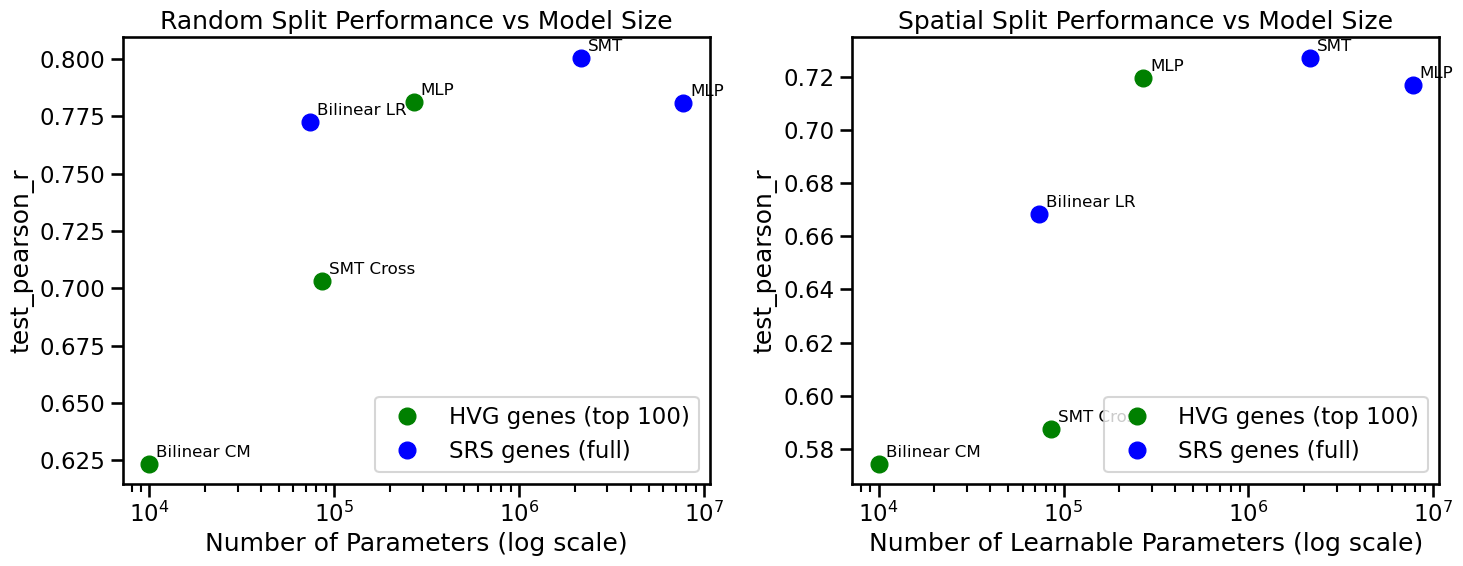

In [80]:
plot_param_count_vs_performance(random_results, spatial_results, metric='test_pearson_r')